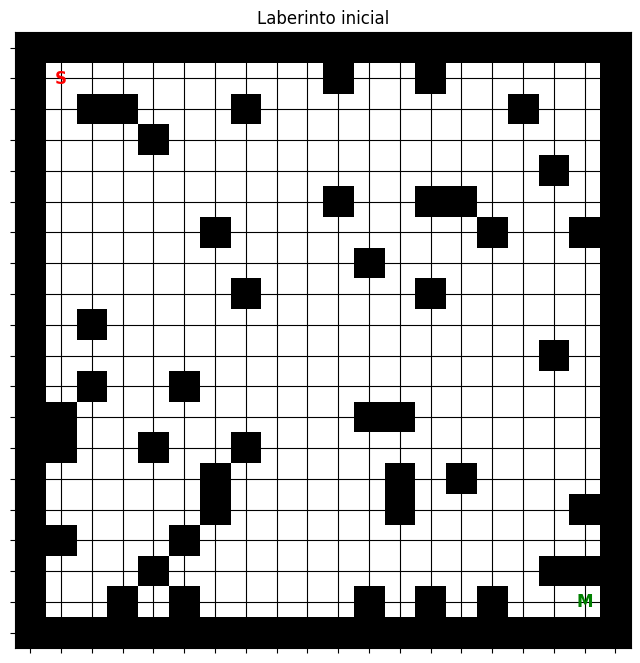

In [2]:
#----------------------------------------------------------------------------
# Agregamos las liberías
#----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

#----------------------------------------------------------------------------
# Definimos las acciones
#----------------------------------------------------------------------------
acciones = [ ( 0 , 1 ), ( 0, -1 ), ( 1, 0 ), ( -1, 0 ) ]  # Derecha, Izquierda, Abajo, Arriba

#----------------------------------------------------------------------------
# Función para elegir una acción epsilon-greedy
#----------------------------------------------------------------------------
def elegir_accion( Q, epsilon, posicion ):
    if np.random.uniform( 0, 1) < epsilon:
        return np.random.choice( len( acciones ) )
    else:
        return np.argmax( Q[ posicion[ 0 ], posicion[ 1 ] ] )

#----------------------------------------------------------------------------
# Función para actualizar la tabla Q usando Q-learning
#----------------------------------------------------------------------------
def actualizar_Q( Q, posicion, accion, recompensa, proxima_posicion, alpha, gamma ):
    max_next_Q = np.max( Q[ proxima_posicion[ 0 ], proxima_posicion[ 1 ] ] )
    Q[ posicion[ 0 ], posicion[ 1 ], accion ] = (1 - alpha) * Q[ posicion[ 0 ], posicion[ 1 ], accion ] + alpha * (
                recompensa + gamma * max_next_Q )
    return Q

#----------------------------------------------------------------------------
# Función para encontrar el camino más corto usando la política aprendida (greedy)
#----------------------------------------------------------------------------
def encontrar_camino_mas_corto( Q, laberinto ):
    posicion = (1, 1)
    camino_mas_corto = [ posicion ]
    while laberinto[ posicion[ 0 ], posicion[ 1 ]] != "M":
        accion = np.argmax( Q[ posicion[ 0 ], posicion[ 1 ] ] )
        proxima_posicion = ( posicion[ 0 ] + acciones[ accion ][ 0 ], posicion[ 1 ] + acciones[ accion ][ 1 ] )
        camino_mas_corto.append( proxima_posicion )
        posicion = proxima_posicion
    return camino_mas_corto

#----------------------------------------------------------------------------
# Función para comprobar la conectividad entre dos puntos en el laberinto
#----------------------------------------------------------------------------
def es_conectado( laberinto, inicio, fin ):
    visitado = set()
    fila_inicial, columna_inicial = inicio
    fila_final, columna_final = fin
    queue = deque( [ ( fila_inicial, columna_inicial ) ] )
    while queue:
        fila, columna = queue.popleft()
        if ( fila, columna)  == ( fila_final, columna_final ):
            return True
        if ( fila, columna ) in visitado or laberinto[ fila, columna ] == '#':
            continue
        visitado.add( ( fila, columna ) )
        for accion in acciones:
            nueva_fila, nueva_columna = fila + accion[ 0 ], columna + accion[ 1 ]
            if 0 <= nueva_fila < laberinto.shape[ 0 ] and 0 <= nueva_columna < laberinto.shape[ 1 ]:
                queue.append( ( nueva_fila, nueva_columna ) )
    return False

#----------------------------------------------------------------------------
# Función para generar un nuevo laberinto
#----------------------------------------------------------------------------
def generar_laberinto( tamaño, obstaculos ):
    laberinto = np.full( ( tamaño, tamaño ), ' ' )
    laberinto[ 0, : ] = laberinto[ -1, : ] = laberinto[ :, 0 ] = laberinto[ :, -1 ] = '#'  # Paredes exteriores
    laberinto[ 1, 1 ] = 'S'  # Posición inicial
    laberinto[ -2, -2 ] = 'M'  # Posición final
    for _ in range( obstaculos ):
        fila, columna = np.random.randint( 1, tamaño - 1 ), np.random.randint( 1, tamaño - 1 )
        if laberinto[ fila ][ columna ] == ' ':
            laberinto[ fila ][ columna ] = "#"
    return laberinto

#----------------------------------------------------------------------------
# Definición del laberinto
#----------------------------------------------------------------------------
tamaño = 20
obstaculos = 50
laberinto = generar_laberinto( tamaño, obstaculos )

#----------------------------------------------------------------------------
# Comprobamos la conectividad entre S y M
#----------------------------------------------------------------------------
conectado = es_conectado( laberinto, ( 1, 1 ), ( tamaño - 2, tamaño - 2 ) )
while not conectado:
    laberinto = generar_laberinto( tamaño, obstaculos )
    conectado = es_conectado( laberinto, ( 1, 1 ), ( tamaño - 2, tamaño - 2 ) )


#----------------------------------------------------------------------------
# Visualizar el laberinto antes de comenzar el entrenamiento
#----------------------------------------------------------------------------
plt.figure( figsize = ( 8, 8 ) )  # Tamaño de la figura
plt.imshow( np.where( laberinto == '#', 0, 1 ), cmap = 'gray', origin = 'upper' )

#----------------------------------------------------------------------------
# Etiquetar la posición inicial y final
#----------------------------------------------------------------------------
posicion_inicial = np.where( laberinto == "S" )
posicion_final = np.where( laberinto == "M" )
plt.text( posicion_inicial[ 1 ], posicion_inicial[ 0 ], "S", ha = 'center', va = 'center', fontsize = 12, fontweight = 'bold', color = 'red' )
plt.text( posicion_final[ 1 ], posicion_final[ 0 ], "M", ha = 'center', va = 'center', fontsize = 12, fontweight = 'bold', color = 'green' )

plt.title( 'Laberinto inicial' )
plt.xticks( np.arange( tamaño ), [] )
plt.yticks( np.arange( tamaño ), [] )
plt.grid( True, color = 'black' )
plt.show()

#----------------------------------------------------------------------------
# Inicialización de la tabla Q
#----------------------------------------------------------------------------
Q = np.zeros( ( laberinto.shape[ 0 ], laberinto.shape[ 1 ], len( acciones ) ) )

#----------------------------------------------------------------------------
# Parámetros del algoritmo Q-learning
#----------------------------------------------------------------------------
alpha = 0.1     # Tasa de aprendizaje
gamma = 0.8     # Factor de descuento
epsilon = 0.2   # Probabilidad de exploración
caminos = 1000  # Número de iteraciones de entrenamiento

#----------------------------------------------------------------------------
# Entrenamiento del agente
#----------------------------------------------------------------------------
for _ in range( caminos ):
    posicion = ( 1, 1 )  # Estado inicial
    while laberinto[ posicion[ 0 ], posicion[ 1 ] ] != "M":  # Mientras no lleguemos a la salida
        accion = elegir_accion( Q, epsilon, posicion )
        proxima_posicion = ( posicion[ 0 ] + acciones[ accion ][ 0 ], posicion[ 1 ] + acciones[ accion ][ 1 ] )
        if laberinto[ proxima_posicion[ 0 ], proxima_posicion[ 1 ] ] == "#":  # Si la próxima acción es una pared
            proxima_posicion = posicion
        if laberinto[ proxima_posicion[ 0 ], proxima_posicion[ 1 ] ] == "M":  # Si llegamos a la salida
            recompensa = 100  # Recompensa alta por alcanzar la salida
        else:
            recompensa = -1
        Q = actualizar_Q( Q, posicion, accion, recompensa, proxima_posicion, alpha, gamma )
        posicion = proxima_posicion

#----------------------------------------------------------------------------
# Encontramos el camino más corto usando la política aprendida (greedy)
#----------------------------------------------------------------------------
camino_mas_corto = encontrar_camino_mas_corto( Q, laberinto )

#----------------------------------------------------------------------------
# Visualizamos el laberinto con el camino más corto
#----------------------------------------------------------------------------
plt.figure( figsize = ( 8, 8 ) )  # Tamaño de la figura
plt.imshow( np.where( laberinto == '#', 0, 1 ), cmap = 'gray', origin = 'upper' )

#----------------------------------------------------------------------------
# Etiquetamos las posiciones inicial y final
#----------------------------------------------------------------------------
for i, pos in enumerate( camino_mas_corto ):
    if i == 0:
        plt.text( pos[ 1 ], pos[ 0 ], "S", ha = 'center', va = 'center', fontsize = 12, fontweight = 'bold', color = 'red' )
    elif i == len( camino_mas_corto ) - 1:
        plt.text( pos[ 1 ], pos[ 0 ], "M", ha = 'center', va = 'center', fontsize = 12, fontweight = 'bold', color = 'green' )
    else:
        plt.text( pos[ 1 ], pos[ 0 ], str( i ), ha = 'center', va = 'center', fontsize = 8, fontweight = 'bold' )

plt.title( 'Laberinto con el camino más corto encontrado mediante Q-learning' )
plt.xticks( np.arange( tamaño ), [] )
plt.yticks( np.arange( tamaño ), [] )
plt.grid( True, color = 'black' )
plt.show()
